In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

def get_sp_tickers(url):
    tables = pd.read_html(url)
    for table in tables:
        for col in table.columns:
#for checking Symbol column exists
            if "Symbol" in col:
                return table[col].tolist()
    return []
def clean_tickers(tickers):
    cleaned_tickers = []
    for ticker in tickers:
        if isinstance(ticker, str):
            # Replace '.' with '-' for Yahoo Finance compatibility
            cleaned_ticker = ticker.replace('.', '-')
            cleaned_tickers.append(cleaned_ticker)
    return list(dict.fromkeys(cleaned_tickers))  # Remove duplicates



# Step 1: Retrieve ticker lists from Wikipedia
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp400_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_400_companies'
sp600_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_600_companies'

sp500_tickers = get_sp_tickers(sp500_url)
sp400_tickers = get_sp_tickers(sp400_url)
sp600_tickers = get_sp_tickers(sp600_url)


tickers = list(set(sp500_tickers 
                   + sp400_tickers + sp600_tickers
                  ))
#yahoo finance ticker formatting.
#tickers = [ticker.replace('.', '-') for ticker in tickers] 
tickers = clean_tickers(tickers)

# Remove duplicates
tickers = list(dict.fromkeys(tickers))
print("Total Unique Tickers Retrieved:", len(tickers))

# Step 2: Download historical data

end_date = datetime.today()- timedelta(days=1)
start_date = end_date - relativedelta(years=12)
data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')
print("Number of tickers in data:", len(data.columns.levels[0]))  # Unique tickers
print("Number of metrics per ticker:", len(data.columns.levels[1])) 
# Print first few rows
print(data.head())

# Ensure Close exists
if 'Close' in data.columns.levels[1]:  
    close_prices_df = data.xs('Close', level=1, axis=1).dropna(axis=1)
    # Debugging: Track removed tickers
    removed_tickers = set(data.columns.levels[0]) - set(close_prices_df.columns)
    print(f"Removed {len(removed_tickers)} tickers due to NaN values:")
    print(removed_tickers if removed_tickers else "None")

else:
    print("Warning: 'Close' data not found!")
    close_prices_df = pd.DataFrame()  # Empty DataFrame as fallback
print("Close Prices Shape:", close_prices_df.shape)  # (rows, columns)
print("Number of tickers after filtering:", close_prices_df.shape[1]) 

# Convert df dataFrame to NumPy array (num_stocks x num_dates) for statistical analysis
close_prices = close_prices_df.T.to_numpy()
#retain the dates reference 
dates = close_prices_df.index
num_stocks, num_dates = close_prices.shape
print("Close Prices in NumPy Shape:", close_prices.shape)  # (rows, columns)

#assert num_stocks >= 1500, f"Only {num_stocks} stocks available, need at least 1500."



Total Unique Tickers Retrieved: 1506
YF.download() has changed argument auto_adjust default to True


[********              17%                       ]  257 of 1506 completed

In [4]:
# Step 3: Mean Reversion Signal-Compute z-scores with rolling past data only
window = 30
close_df = pd.DataFrame(close_prices.T, index=dates, columns=close_prices_df.columns)
MA = close_df.rolling(window=window, min_periods=window).mean().shift(1)
sigma = close_df.rolling(window=window, min_periods=window).std().shift(1)
z_scores = (close_df - MA) / sigma
print("Missing Z-Scores:", z_scores.isna().sum().sum())
print(z_scores.iloc[-5:])  # Last 5 rows
z_scores_np = z_scores.to_numpy().T # (num_stocks, num_dates)


Missing Z-Scores: 36085
Ticker          CACI      MYGN      MPWR       AEO      AVGO       ARI  \
Date                                                                     
2025-02-24 -1.633406  0.513776  0.006850 -1.776293 -1.875638  1.178777   
2025-02-25 -1.386995 -1.676723 -0.053795 -2.130402 -2.201358  1.609661   
2025-02-26 -1.317332 -1.778980  0.410637 -1.843386 -1.104035  1.458962   
2025-02-27 -1.129678 -2.186091 -1.322344 -1.980836 -2.300899  1.402359   
2025-02-28 -1.077516 -2.294830 -1.335186 -1.794296 -1.928420  1.419444   

Ticker           ATR       FRT      PCAR       OXY  ...      SCHL       ARW  \
Date                                                ...                       
2025-02-24 -1.135032 -0.467772 -0.765789  0.172141  ...  1.950349 -0.403195   
2025-02-25 -0.730899 -0.492070 -0.573731 -0.306860  ...  1.859077 -0.806546   
2025-02-26 -0.867326 -0.795846 -0.840349 -0.448480  ...  2.276765 -0.849769   
2025-02-27 -0.981126 -1.252226 -1.049821 -0.340897  ...  2.244

In [21]:
# Step 4: Portfolio construction
N = 150 #150 stocks long and 150 stocks short
position_size = 1000
positions = np.zeros((num_stocks, num_dates))

for t in range(window, num_dates):
    z_t = z_scores_np[:, t]
    valid_idx = ~np.isnan(z_t)
    z_valid = z_t[valid_idx]
    stocks_valid = np.arange(num_stocks)[valid_idx]
    
    if len(z_valid) < 2 * N:
        print(f"  Skipping day {t}: Insufficient stocks ({len(z_valid)} < {2 * N})")
        continue
    
    ranks = np.argsort(z_valid)
    long_idx = stocks_valid[ranks[:N]]
    short_idx = stocks_valid[ranks[-N:]]
    
    positions[long_idx, t] = position_size / close_prices[long_idx, t]
    positions[short_idx, t] = -position_size / close_prices[short_idx, t]




IndexError: boolean index did not match indexed array along axis 0; size of axis is 1199 but size of corresponding boolean axis is 1200

In [15]:
# Step 5: Compute PnL
print(f"close_prices shape: {close_prices.shape}")
print(f"positions shape: {positions.shape}")
price_diff = close_prices[:, 1:] - close_prices[:, :-1]
positions_shifted = positions[:, :-1]
daily_pnl = np.sum(positions_shifted * price_diff, axis=0)

# Align daily_pnl with tradable days (after window)
daily_pnl = daily_pnl[window:]  # Length: num_dates - 1 - window

# Diagnostics
print(f"price_diff shape: {price_diff.shape}")
print(f"positions_shifted shape: {positions_shifted.shape}")
print(f"daily_pnl length: {len(daily_pnl)}")
print(f"Sample daily_pnl (first 5 days after window): {daily_pnl[:5]}")
print(f"Number of NaNs in daily_pnl: {np.isnan(daily_pnl).sum()}")
print(f"Number of zeros in daily_pnl: {(daily_pnl == 0).sum()}")

# Check total PnL over a few days
sample_days = 7
total_pnl_sample = np.sum(daily_pnl[:sample_days])
print(f"Total PnL over first {sample_days} tradable days: ${total_pnl_sample:.2f}")

close_prices shape: (1200, 3019)
positions shape: (1200, 3019)
price_diff shape: (1200, 3018)
positions_shifted shape: (1200, 3018)
daily_pnl length: 2988
Sample daily_pnl (first 5 days after window): [ 802.49139618 -780.30111745 -374.37287441 -816.37295685  229.30729176]
Number of NaNs in daily_pnl: 0
Number of zeros in daily_pnl: 0
Total PnL over first 7 tradable days: $2584.89


In [16]:
# Step 6: Performance metrics
gross_exposure = 2 * N * position_size
daily_returns = daily_pnl / gross_exposure
daily_returns = daily_returns[~np.isnan(daily_returns)]  # Remove NaNs
cumulative_returns = np.cumprod(1 + daily_returns) - 1
# assuming risk free rate of 0
sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
annualised_return = np.mean(daily_returns) * 252
wealth = np.cumprod(1 + daily_returns)
running_max = np.maximum.accumulate(wealth)
drawdowns = (running_max - wealth) / running_max
max_drawdown = np.max(drawdowns)

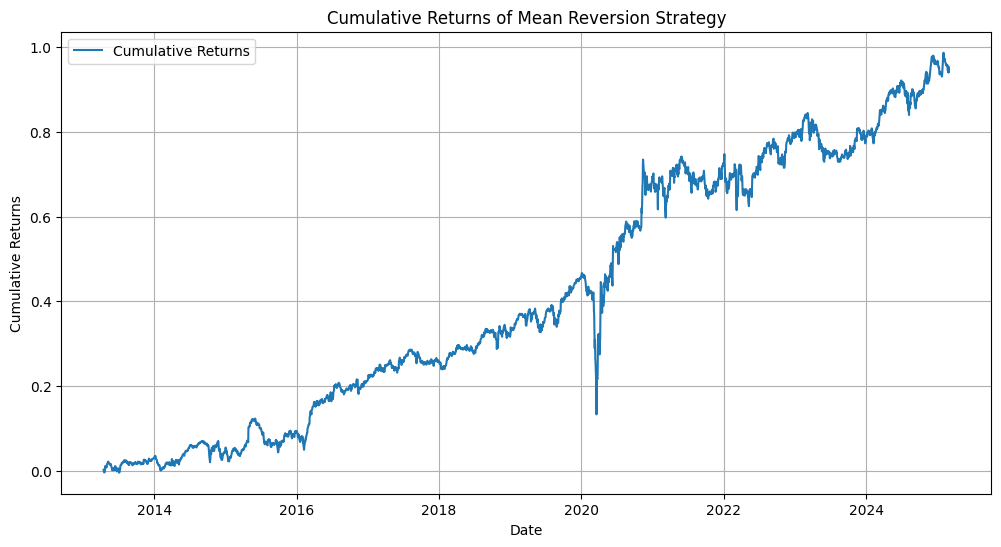

Sharpe Ratio: 0.72
Annualized Return: 5.94%
Maximum Drawdown: 22.75%


In [18]:
# Step 7: Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(dates[window+1:], cumulative_returns, label='Cumulative Returns')
plt.title('Cumulative Returns of Mean Reversion Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# Display performance metrics
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Annualized Return: {annualised_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")